# And End-to-end ML project

2021-10-28

Author: Fernando Carazo


    Table of Contents
    Scikit-learn
    Introduction
    Library
    Data
    Exploratory analysis
        Type of each column
        Number of observations and missing values
        Response variable
        Numerical variables
        Numerical variables correlation
        Qualitative variables
    Train and test division
    Preprocessed
        Imputation of missing values
        Exclusion of variables with variance close to zero
        Standardization and scaling of numerical variables
        Binarization of qualitative variables
        Pipeline and ColumnTransformer
    Create a model
        Training
        Validation
        Prediction
        Test error
        Hyperparameters (tuning)
        Grid search
        Random grid search
        Bayesian optimization
        Preprocessing tuning
    Algorithms
        K-Nearest Neighbor (kNN)
        Linear Regression (Ridge and Lasso)
        Random Forest
        Gradient Boosting Trees
    Stacking
        Super Learner algorithm
        Comparison
    Annexes
    Annex 1: Validation methods
    Annex 2: Metrics
    Bibliography
    PrivacyPrivacy
    Machine learning with Python and Scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%config Completer.use_jedi = False
%matplotlib inline

In [2]:
# Config matplotlib
# ==============================================================================
plt.rcParams['figure.figsize'] = [10, 8]


# Config warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [3]:
datos_rd = pd.read_csv('./data/SaratogaHouses.csv', sep=",")
datos = datos_rd.copy()

In [4]:
datos.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes


In [5]:
datos.shape

(1728, 16)

## Data


The SaratogaHouses dataset from the R mosaicData package contains information on the price of 1,728 homes located in Saratoga County, New York, USA in 2006. In addition to price, it includes 15 additional variables:

    price: house price.
    lotSize: square meters of the house.
    age: age of the house.
    landValue: value of the land.
    livingArea: habitable square meters.
    pctCollege - Percentage of the neighborhood with a college degree.
    bedrooms: number of bedrooms.
    firplaces: number of chimneys.
    bathrooms: number of bathrooms (the value 0.5 refers to bathrooms without a shower).
    rooms: number of rooms.
    heating: type of heating.
    fuel: type of heating feed (gas, electricity or diesel).
    sewer: type of drain.
    waterfront: if the house has views of the lake.
    newConstruction: if the house is newly built.
    centralAir: if the house has air conditioning.
    
Data can be downloaded in csv format from SaratogaHouses.csv

**The goal is to obtain a model capable of predicting the rental price.**

## Exploratory analysis


Before training a predictive model, or even before performing any calculations on a new data set, it is very important to perform a descriptive exploration of the data. This process makes it possible to better understand what information each variable contains, as well as to detect possible errors. Some common examples are:

1. That a column has been stored with the wrong type: a numeric variable is being recognized as text or vice versa.

2. That a variable contains values that do not make sense: for example, to indicate that the price of a house is not available, enter the value 0 or a blank space.

3. That a word has been entered in a numeric type variable instead of a number.

Furthermore, this initial analysis can provide clues as to which variables are suitable as predictors in a model (more on this in the following sections).

### Column type

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
price              1728 non-null int64
lotSize            1728 non-null float64
age                1728 non-null int64
landValue          1728 non-null int64
livingArea         1728 non-null int64
pctCollege         1728 non-null int64
bedrooms           1728 non-null int64
fireplaces         1728 non-null int64
bathrooms          1728 non-null float64
rooms              1728 non-null int64
heating            1728 non-null object
fuel               1728 non-null object
sewer              1728 non-null object
waterfront         1728 non-null object
newConstruction    1728 non-null object
centralAir         1728 non-null object
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB


### Number of observations and missing values

Together with the study of the type of variables, it is essential to know the number of available observations and if all of them are complete. Missing values are very important when creating models, most algorithms do not accept incomplete observations or are highly influenced by them. Although the imputation of missing values is part of the preprocessing and, therefore, should be learned only with the training data, its identification has to be done before separating the data to ensure that all the necessary imputation strategies are established.

In [7]:
datos.shape

(1728, 16)

In [8]:
datos.isna().sum()

price              0
lotSize            0
age                0
landValue          0
livingArea         0
pctCollege         0
bedrooms           0
fireplaces         0
bathrooms          0
rooms              0
heating            0
fuel               0
sewer              0
waterfront         0
newConstruction    0
centralAir         0
dtype: int64

No variable contains missing values. In the imputation of missing values section, various imputation strategies are shown when the data set is incomplete.

### Response variable
When creating a model, it is very important to study the distribution of the response variable, since, after all, it is what we want to predict. The price variable has an asymmetric distribution with a positive tail due to the fact that a few houses have a price much higher than the average. This type of distribution is usually best visualized after applying the logarithmic or the square root.

<AxesSubplot:xlabel='price', ylabel='Density'>

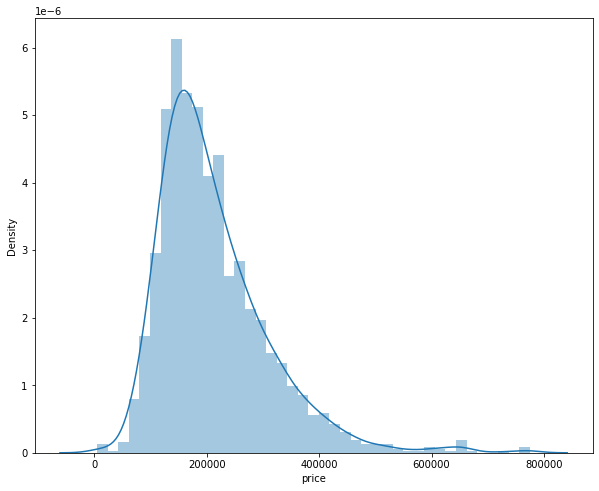

In [9]:
sns.distplot(datos['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

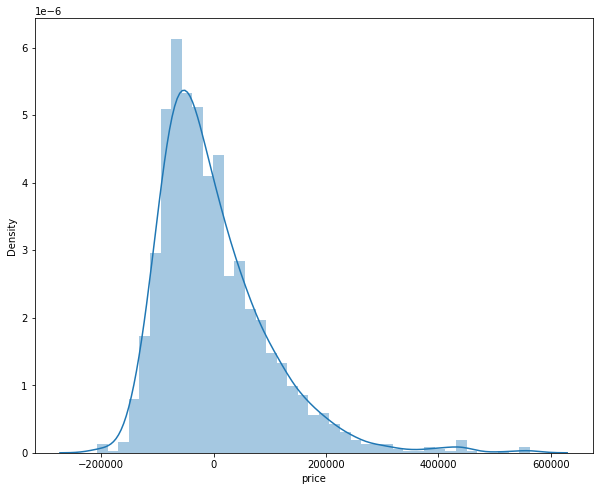

In [10]:
mean = datos.price.mean()
price_minus_mean =datos['price'] - mean
sns.distplot(price_minus_mean)

In [11]:
rmse = (np.sum(price_minus_mean**2)/len(price_minus_mean))
(rmse)

9685099416.739046

In [12]:
datos['price'].mean()

211966.7054398148

In [13]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_true=datos.price, y_pred=np.repeat(datos.price.mean(), len(price_minus_mean))))

98412.90269440814

<AxesSubplot:xlabel='price', ylabel='Density'>

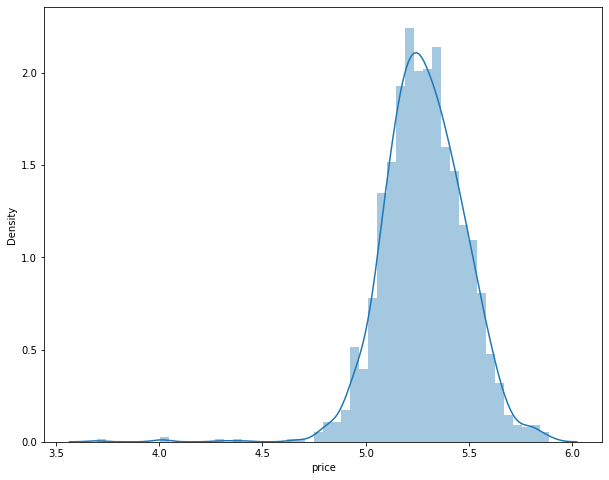

In [14]:
sns.distplot(np.log10(datos['price']))


### Numerical features 

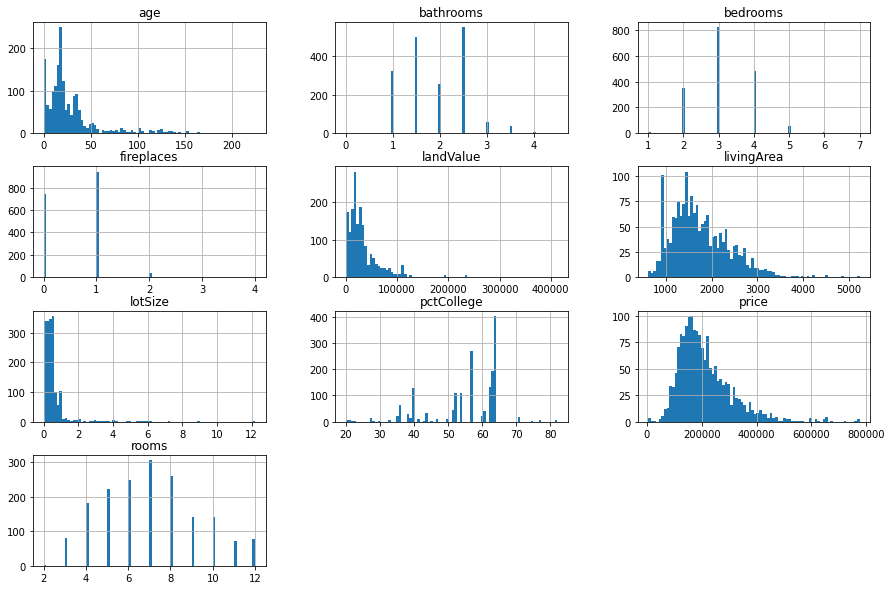

In [15]:
datos.hist(bins=80, figsize=(15,10));


The chimney variable, although it is of a numerical type, only takes a few values and the vast majority of observations belong to only two of them. In cases like this, it is often convenient to treat the variable as binary.

In [16]:
datos['fireplaces_bin'] = 1
datos.loc[datos['fireplaces'] == 0, 'fireplaces_bin'] = 0
datos.drop(columns='fireplaces', inplace=True)

In [17]:
datos[(datos['price'] < 100000) & (datos['bedrooms'] == 2)].head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin
4,86060,0.11,0,15000,840,51,2,1.0,3,hot air,gas,public/commercial,No,Yes,Yes,0
12,85860,8.97,13,4800,704,41,2,1.0,4,electric,electric,septic,No,No,No,0
18,60000,0.21,82,8500,924,35,2,1.0,6,hot water/steam,oil,septic,No,No,No,0
51,64500,0.06,16,1600,1480,52,2,2.5,5,hot air,gas,public/commercial,No,No,No,1
56,90000,0.07,14,1800,1480,52,2,2.5,5,hot air,gas,public/commercial,No,No,Yes,1


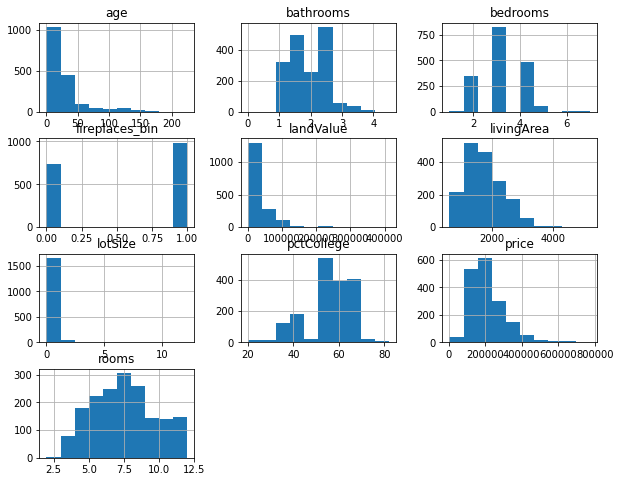

In [18]:
datos.hist();

As the objective of the study is to predict the price of houses, the analysis of each variable is also done in relation to the price response variable. By analyzing the data in this way, you can begin to get ideas about which variables are most related to price and in what way.

In [19]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
price              1728 non-null int64
lotSize            1728 non-null float64
age                1728 non-null int64
landValue          1728 non-null int64
livingArea         1728 non-null int64
pctCollege         1728 non-null int64
bedrooms           1728 non-null int64
bathrooms          1728 non-null float64
rooms              1728 non-null int64
heating            1728 non-null object
fuel               1728 non-null object
sewer              1728 non-null object
waterfront         1728 non-null object
newConstruction    1728 non-null object
centralAir         1728 non-null object
fireplaces_bin     1728 non-null int64
dtypes: float64(2), int64(8), object(6)
memory usage: 216.1+ KB


### Numerical variables correlation


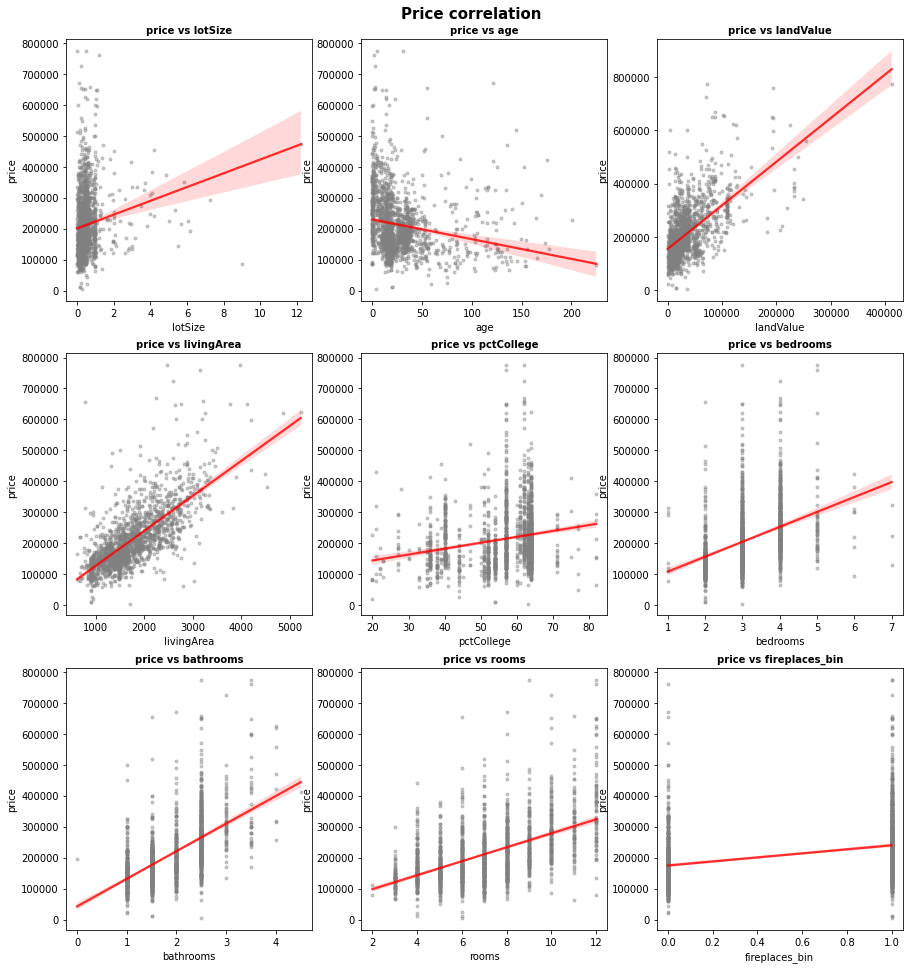

In [20]:
numeric_cols = datos.select_dtypes(['int64', 'float64']).columns
numeric_cols = numeric_cols.drop(['price'])

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
ax = ax.flat

for i, c in enumerate(numeric_cols):
    sns.regplot(data=datos, x=c, 
                y='price', 
                ax=ax[i], 
                color = 'gray', 
                marker='.',
                scatter_kws={'alpha':0.4},
                line_kws={'color':'red', 'alpha':0.8});
    
    ax[i].set_title(f"price vs {c}", fontsize = 10, fontweight = "bold")
    
plt.subplots_adjust(top=0.95)
fig.suptitle('Price correlation', fontsize = 15, fontweight = "bold");
plt.show()


In [21]:
data_cor = datos.corr(method='pearson')

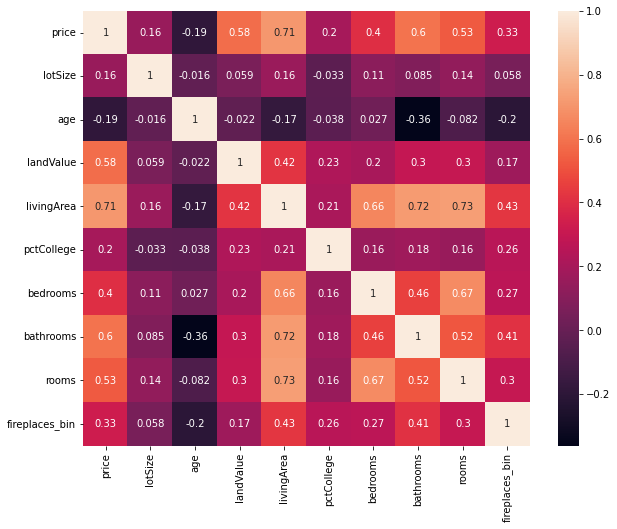

In [22]:
fig = sns.heatmap(data_cor, annot=True)


##        Qualitative variables



        

In [23]:
datos.select_dtypes(include=['object']).describe()


,heating,fuel,sewer,waterfront,newConstruction,centralAir
count,1728,1728,1728,1728,1728,1728
unique,3,3,3,2,2,2
top,hot air,gas,public/commercial,No,No,No
freq,1121,1197,1213,1713,1647,1093


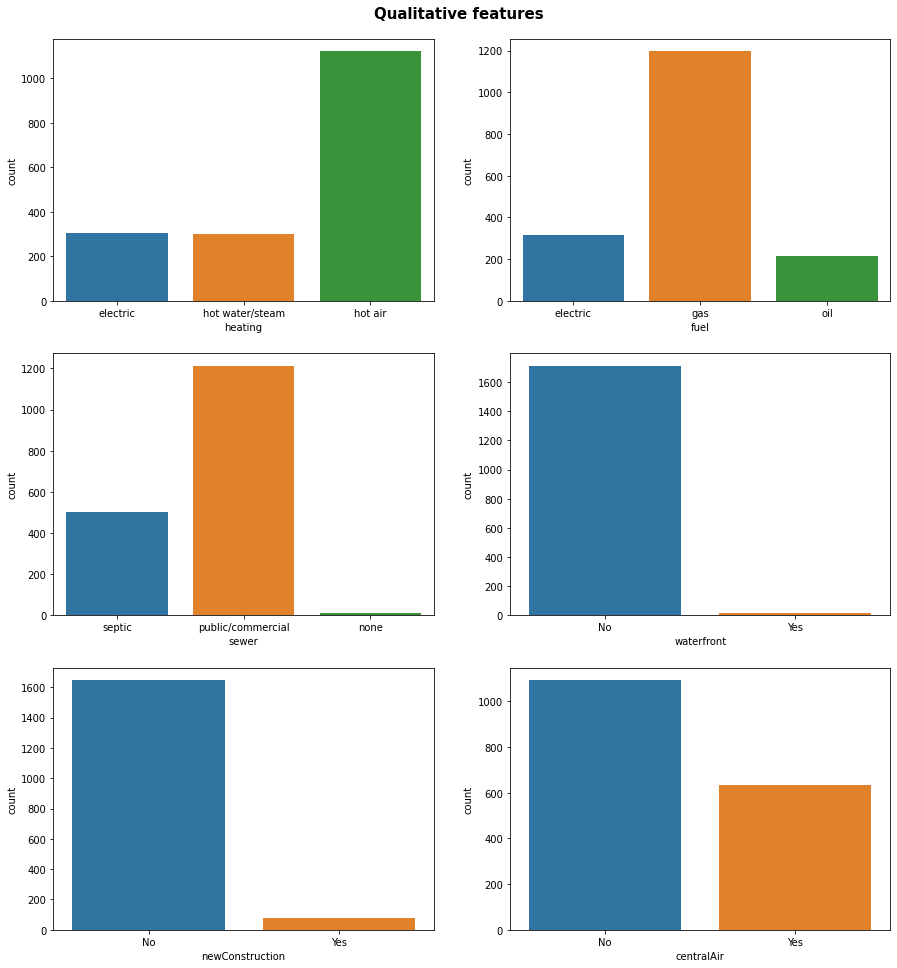

In [24]:
cat_columns = datos.select_dtypes(include=['object']).columns

fig, ax = plt.subplots(3,2, figsize=(15,15))
ax = ax.flat

for i, c in enumerate(cat_columns):
    sns.countplot(datos[c], ax=ax[i])

plt.subplots_adjust(top=0.95)
fig.suptitle('Qualitative features', fontsize = 15, fontweight = "bold");

If any of the levels of a qualitative variable has very few observations compared to the other levels, it may happen that, during cross validation or bootstrapping, some partitions do not contain any observations of that class (zero variance), which can lead to to errors. In these cases, it is usually convenient:

- Eliminate the minority group observations if it is a multiclass variable.

- Delete the variable if it only has two levels.

- Group minority levels into a single group.

- Ensure that, when creating partitions, all groups are represented in each one of them.

In this case, you have to be careful with the chimney variable. Levels 2, 3 and 4 are unified in a new level called "2_mas".

### Price vs qualitative variables

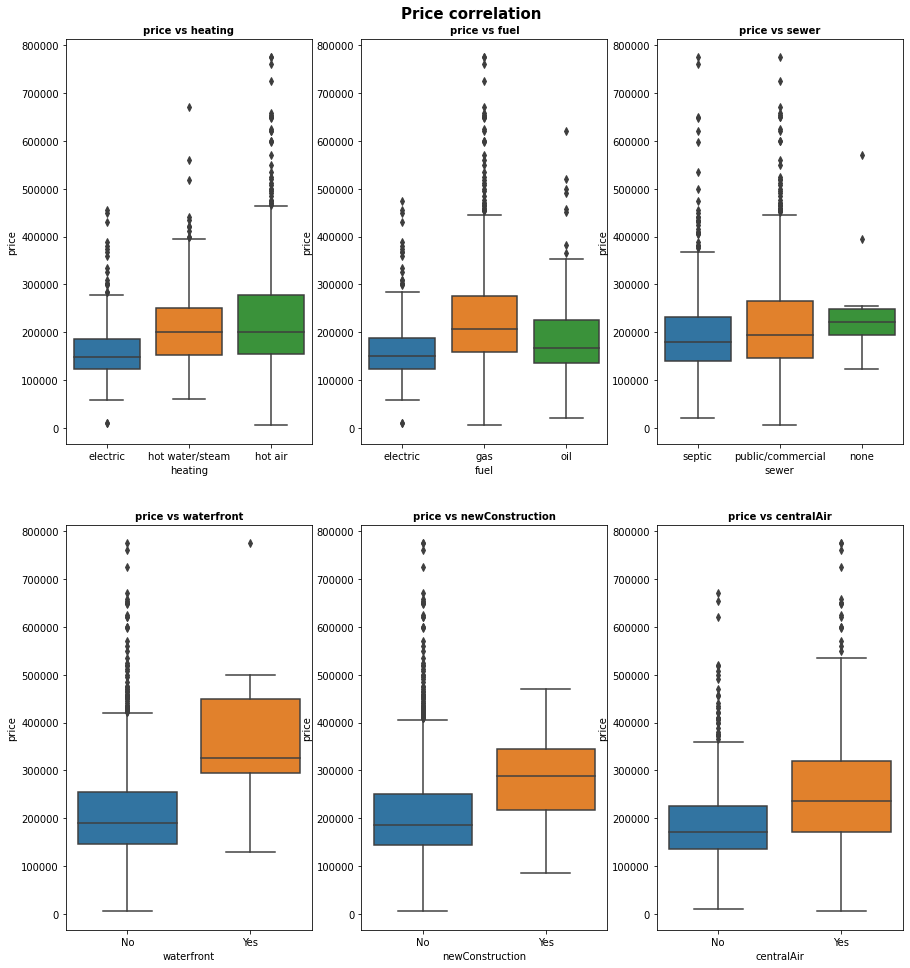

In [25]:

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,15))
ax = ax.flat

for i, c in enumerate(cat_columns):
    sns.boxplot(
        x     = c,
        y     = 'price',
        data  = datos,
        ax    = ax[i]
    )
    
    ax[i].set_title(f"price vs {c}", fontsize = 10, fontweight = "bold")


plt.subplots_adjust(top=0.95)
fig.suptitle('Price correlation', fontsize = 15, fontweight = "bold");
plt.show()

## Train and test division


Evaluating the predictive capacity of a model consists of checking how close its predictions are to the true values ​​of the response variable. To be able to quantify it correctly, it is necessary to have a set of observations, of which the response variable is known, but that the model has not "seen", that is, they have not participated in its adjustment. For this purpose, the available data are divided into a training set and a test set. The proper size of the partitions depends largely on the amount of data available and the security that is needed in the estimation of the error, 80% -20% usually gives good results. The distribution must be done in a random or random-stratified way.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('price', axis = 'columns'),
                                        datos['price'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

It is important to verify that the distribution of the response variable is similar in the training and test sets. To ensure that this is true, the scikit-learn function train_test_split () allows, in classification problems, to identify with the stratify argument the variable based on which to make the distribution.

This type of stratified distribution ensures that the training set and the test set are similar in terms of the response variable, however, it does not guarantee that the same occurs with the predictors. For example, in a data set with 100 observations, a binary predictor that has 90 observations from one group and only 10 from another has a high risk that, in some of the partitions, the minority group has no representatives. If this occurs in the training set, some algorithms will fail when applied to the test set, since they will not understand the value that is being passed to them. This problem can be avoided by eliminating variables with variance close to zero (see below).
    

# Preprocessed


The preprocessing encompasses all those transformations carried out on the data in order that they can be interpreted by the machine learning algorithm as efficiently as possible. All data preprocessing must be learned from the training observations and then applied to the training set and the test set. This is very important so as not to violate the condition that no information from the test observations participates or influences the fit of the model. This principle should also apply if cross-validation is used (see below). In this case, the preprocessing must be done within each validation iteration, so that the estimates made with each validation partition do not contain information from the rest of the partitions. Although it is not possible to create a single listing, some of the most commonly required preprocessing steps are summarized below.

## Imputation of missing values


The vast majority of algorithms do not accept incomplete observations, so when the data set contains missing values, it is possible to:

- Eliminate those observations that are incomplete.

- Eliminate those variables that contain missing values.

- Try to estimate the missing values using the rest of the available information (imputation).

The first two options, although simple, involve losing information. Observation removal can only be applied when many are available and the percentage of incomplete records is very low. In the case of eliminating variables, the impact will depend on how much information these variables contribute to the model. When using imputation, it is very important to take into account the risk involved in entering values in predictors that have a lot of influence on the model. Suppose a medical study in which, when one of the predictors is positive, the model almost always predicts that the patient is healthy. For a patient whose value of this predictor is unknown, the risk that the imputation is wrong is very high, so it is preferable to obtain a prediction based only on the information available. This is another example of the importance of the analyst knowing the problem he is facing and thus being able to make the best decision.

The sklearn.impute module incorporates several different imputation methods:

- SimpleImputer: allows imputations using a constant value or a statistic (mean, median, most frequent value) from the same column in which the missing value is found.

- IterativeImputer: allows you to impute the value of a column taking into account the rest of the columns. Specifically, it is an iterative process in which, in each iteration, one of the variables is used as the response variable and the rest as predictors. Once the model is obtained, it is used to predict the empty positions of that variable. This process is carried out with each variable and the cycle is repeated max_iter times to gain stability. The implementation of sklearn.impute.IterativeImputer allows almost any of its algorithms to be used to create the imputation models (KNN, RandomForest, GradientBoosting ...).

- KNNImputer: it is a specific case of IterativeImputer in which k-Nearest Neighbors is used as the imputation algorithm.

Despite being a widely used method, imputing using KNN presents two problems: its high computational cost means that it is only applicable in data sets of small or moderate size. If there are categorical variables, due to the difficulty of measuring "distances" in this context, it can lead to unrealistic results. For these two reasons, it is more advisable to use a Random `Forest IterativeImputer (predictor = RandomForestRegressor ())` model.

With the argument add_indicator = True, a new column is automatically created in which the value 1 indicates which values ​​have been imputed. This can be useful both to identify the observations in which some imputation has been made and to use it as one more predictor in the model.

In [27]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(X))


[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


## Exclusion of variables with variance close to zero


Predictors that contain a single value (zero-variance) should not be included in the model as they do not provide information. Nor is it convenient to include predictors that have a variance close to zero, that is, predictors that take only a few values, of which some appear very infrequently. The problem with the latter is that they can become predictors with zero variance when the observations are split by cross-validation or bootstrap.

The VarianceThreshold class of the sklearn.feature_selection module identifies and excludes all those predictors whose variance does not exceed a certain threshold. In the case of qualitative variables, it should be remembered that scikitlearn requires that they be binarized (one hot encoding or dummy) in order to train the models. A Boolean variable follows a Bernoulli distribution, so its variance can be calculated as:

$Var [X] = p (1 − p)$
 
Although the elimination of non-informative predictors could be considered a proper step of the predictor selection process, since it consists of filtering by variance, it has to be done before standardizing the data, since afterwards, all predictors have variance 1.

## Standardization and scaling of numerical variables


When the predictors are numerical, the scale on which they are measured, as well as the magnitude of their variance can greatly influence the model. Many machine learning algorithms (SVM, neural networks, lasso ...) are sensitive to this, so that, if the predictors are not equal in some way, those that are measured on a larger scale or that have more variance will dominate the model even though they are not the ones most closely related to the response variable. There are mainly 2 strategies to avoid it:

- Centered: consists of subtracting from each value the mean of the predictor to which it belongs. If the data is stored in a dataframe, centering is achieved by subtracting the mean of the column in which it is located from each value. As a result of this transformation, all predictors have a mean of zero, that is, the values are centered around the origin. StandardScaler (with_std = False)

- Normalization (standardization): consists of transforming the data so that all predictors are approximately on the same scale. There are two ways to do this:

- Z-score normalization (StandardScaler): divide each predictor by its standard deviation after having been centered, in this way, the data has a normal distribution.

$$z = (x − μ)/σ$$
 
Max-min standardization (MinMaxScaler): transform the data so that it is within the range [0, 1].

$$X_{norm} = (X − X_{min})/(X_{max} − X_{min})$$
 
Variables should never be standardized after being binarized (see below).

## Binarization of qualitative variables


Binarization (one-hot-encoding) consists of creating new dummy variables with each of the levels of the qualitative variables. For example, a variable named color that contains the levels red, green and blue, will be converted into three new variables (color_red, color_green, color_blue), all with the value 0 except the one that matches the observation, which takes the value 1.

By default, the OneHotEncoder class binarizes all variables, so it must only be applied to qualitative variables (see how to do it in the ColumnTransformer section). With the drop = ‘first’ argument, one of the levels is eliminated to avoid redundancies. Going back to the previous example, it is not necessary to store the three variables, since, if color_red and color_green take the value 0, the variable color_blue necessarily takes the value 1. If color_red or color_green take the value 1, then color_blue is necessarily 0. This it is important in models that suffer problems if the predictors are perfectly correlated (linear models without regularization, neural networks ...).

In certain scenarios it may happen that, in the test data, a new level appears that was not in the training data. If you don't know in advance what all the possible levels are, you can avoid prediction errors by specifying OneHotEncoder (handle_unknown = 'ignore').

The way to preprocess the data within the scikit-learn ecosystem is by using the ColumnTransformer and pipeline. In addition to those already mentioned, many more preprocessing transformations can be found in the sklearn.preprocessing module.

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382 entries, 1571 to 815
Data columns (total 15 columns):
lotSize            1382 non-null float64
age                1382 non-null int64
landValue          1382 non-null int64
livingArea         1382 non-null int64
pctCollege         1382 non-null int64
bedrooms           1382 non-null int64
bathrooms          1382 non-null float64
rooms              1382 non-null int64
heating            1382 non-null object
fuel               1382 non-null object
sewer              1382 non-null object
waterfront         1382 non-null object
newConstruction    1382 non-null object
centralAir         1382 non-null object
fireplaces_bin     1382 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 172.8+ KB


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
# from sklearn.compose import make_column_selector

# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()

In [30]:
numeric_cols

['lotSize',
 'age',
 'landValue',
 'livingArea',
 'pctCollege',
 'bedrooms',
 'bathrooms',
 'rooms',
 'fireplaces_bin']

In [31]:
preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

In [32]:
preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [33]:
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
# datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(X_train_prep, columns=labels)
datos_train_prep.head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,heating_electric,...,fuel_oil,sewer_none,sewer_public/commercial,sewer_septic,waterfront_No,waterfront_Yes,newConstruction_No,newConstruction_Yes,centralAir_No,centralAir_Yes
0,-0.061549,0.301597,-0.195148,1.320467,0.826826,1.011039,0.905289,2.128665,0.875936,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.195573,-0.407560,-0.277982,0.194931,0.730235,1.011039,1.663079,1.264569,0.875936,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.072475,-0.478476,-0.892092,-0.064313,-1.877728,1.011039,0.147500,-0.463623,-1.141636,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.121115,0.159766,-0.138022,0.254509,0.730235,-0.200805,-0.610289,-0.895671,0.875936,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.523186,-0.974885,0.050496,0.484768,0.150688,-0.200805,0.905289,0.832521,0.875936,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [34]:
X_train['fuel'].unique()

array(['gas', 'oil', 'electric'], dtype=object)

In [35]:
datos_train_prep.columns.tolist()

['lotSize',
 'age',
 'landValue',
 'livingArea',
 'pctCollege',
 'bedrooms',
 'bathrooms',
 'rooms',
 'fireplaces_bin',
 'heating_electric',
 'heating_hot air',
 'heating_hot water/steam',
 'fuel_electric',
 'fuel_gas',
 'fuel_oil',
 'sewer_none',
 'sewer_public/commercial',
 'sewer_septic',
 'waterfront_No',
 'waterfront_Yes',
 'newConstruction_No',
 'newConstruction_Yes',
 'centralAir_No',
 'centralAir_Yes']

In [36]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()

In [37]:
lm.fit(X=datos_train_prep, y=y_train)

LinearRegression()

In [38]:
from sklearn import metrics

np.sqrt(metrics.mean_squared_error(y_pred= lm.predict(datos_train_prep), y_true=y_train))


56090.71927293373

In [39]:
from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_pred=lm.predict(datos_train_prep), y_true=y_train))

56090.71927293373

In [40]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = lm,
                X         = datos_train_prep,
                y         = y_train,
                 scoring   = 'neg_mean_squared_error',
                cv        = 10
             )

In [41]:
pd.Series(np.sqrt(-cv_scores)).describe()


count       10.000000
mean     56658.384308
std       7850.841812
min      45618.981902
25%      50524.954698
50%      57600.928305
75%      62114.078748
max      67810.764665
dtype: float64

In [42]:
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import cross_validate

In [43]:
np.sqrt(-cv_scores)/datos['price'].mean()

array([0.23671995, 0.27254594, 0.22515098, 0.27235587, 0.31991234,
       0.27113447, 0.2998673 , 0.31678964, 0.21521768, 0.24329093])

In [44]:
print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-2.51770597e+09 -3.33744967e+09 -2.27762891e+09 -3.33279637e+09
 -4.59829980e+09 -3.30297103e+09 -4.04011304e+09 -4.50896903e+09
 -2.08109151e+09 -2.65942125e+09]
Média métricas de validación cruzada: -3265644657.8309116


In [45]:
val = cross_validate(
                estimator = lm,
                X         = datos_train_prep,
                y         = y_train,
                 scoring   = 'neg_mean_squared_error',
                cv        = 10)

In [46]:
lm = LinearRegression()
lm.fit(X=datos_train_prep, y=y_train)

LinearRegression()

In [47]:
pred_test = lm.predict(X_test_prep)

np.sqrt(metrics.mean_squared_error(y_pred=pred_test, y_true=y_test))/datos['price'].mean()

0.3073433520569194

In [48]:
datos['price_up_200k'] = False
datos.loc[datos['price'] > 200000, 'price_up_200k'] = True

In [49]:
datos.head()

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin,price_up_200k
0,132500,0.09,42,50000,906,35,2,1.0,5,electric,electric,septic,No,No,No,1,False
1,181115,0.92,0,22300,1953,51,3,2.5,6,hot water/steam,gas,septic,No,No,No,0,False
2,109000,0.19,133,7300,1944,51,4,1.0,8,hot water/steam,gas,public/commercial,No,No,No,1,False
3,155000,0.41,13,18700,1944,51,3,1.5,5,hot air,gas,septic,No,No,No,1,False
4,86060,0.11,0,15000,840,51,2,1.0,3,hot air,gas,public/commercial,No,Yes,Yes,0,False


In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X=datos_train_prep, y=y_train)

RandomForestRegressor()

In [51]:
cv_scores = cross_val_score(
                estimator = rf,
                X         = datos_train_prep,
                y         = y_train,
                 scoring   = 'neg_mean_squared_error',
                cv        = 10
             )
np.sqrt(-cv_scores)/datos['price'].mean()

array([0.25123052, 0.2662393 , 0.20266874, 0.22696843, 0.30371438,
       0.25341184, 0.31977509, 0.31303122, 0.23488674, 0.23510205])

In [56]:
from utils import model_diagnosis

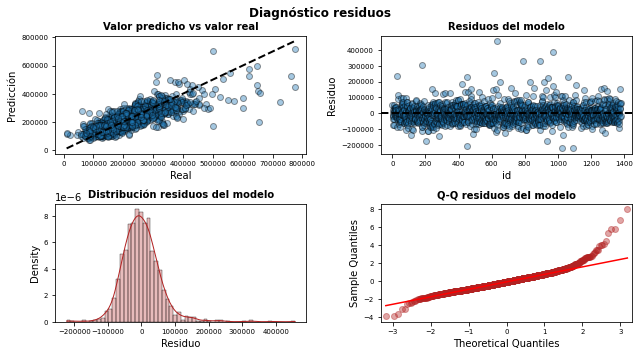

In [57]:
model_diagnosis(X_train=datos_train_prep, pipe=lm, y_train=y_train)

## Pipeline and ColumnTransformer


The ColumnTransformer and make_column_transformer classes in the sklearn.compose module allow you to combine multiple preprocessing transformations, specifying which columns each one applies to. Like all transformers, it has a training method (fit) and a transformation method (transform). This allows transformation learning to be done with training observations only, and can then be applied to any data set. The idea behind this module is the following:

Define all the transformations (scaling, selection, filtering ...) that you want to apply and to which ColumnTransformer () columns. Column selection can be done by: name. index, boolean mask, slice, regex pattern, by column type or with the `make_column_selector` selection functions.

Learn the necessary parameters for these transformations with the training observations `.fit ()`.

Apply the learned transformations to any set by `.transform()`.

Once the ColumnTransformer object has been defined, the fit () method learns the transformations with the training data and applies them to the two sets with transform ().

The result returned by ColumnTransformer is a numpy array, so the column names are lost. It is usually interesting to be able to inspect how the dataset looks after preprocessing in dataframe format. By default, OneHotEncoder sorts new columns alphabetically from left to right.

ColumnTransformer applies operations in parallel, not sequentially, this means that it does not allow more than one transformation to be applied to the same column. In the event that it is necessary to do so, we must resort to pipeline, which also group operations but execute them sequentially, so that the output of one operation is the input of the next. If you want to apply several preprocessing transformations on the same column, you must first group them in a pipeline

The following example combines the transformations:

Numeric columns: missing values ​​are imputed with the median and then standardized.

Categorical (qualitative) columns: missing values ​​are imputed with the most frequent value and then one hot encoding is applied.


As of scikit-learn version 0.23, an interactive representation of a pipeline object can be created.


In [58]:
datos.iloc[1:3,1:] = np.nan

In [72]:
datos

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin,price_up_200k
0,132500,0.09,42.0,50000.0,906.0,35.0,2.0,1.0,5.0,electric,electric,septic,No,No,No,1.0,0.0
1,181115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,109000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,155000,0.41,13.0,18700.0,1944.0,51.0,3.0,1.5,5.0,hot air,gas,septic,No,No,No,1.0,0.0
4,86060,0.11,0.0,15000.0,840.0,51.0,2.0,1.0,3.0,hot air,gas,public/commercial,No,Yes,Yes,0.0,0.0
5,120000,0.68,31.0,14000.0,1152.0,22.0,4.0,1.0,8.0,hot air,gas,septic,No,No,No,1.0,0.0
6,153000,0.40,33.0,23300.0,2752.0,51.0,4.0,1.5,8.0,hot water/steam,oil,septic,No,No,No,1.0,0.0
7,170000,1.21,23.0,14600.0,1662.0,35.0,4.0,1.5,9.0,hot air,oil,septic,No,No,No,1.0,0.0
8,90000,0.83,36.0,22200.0,1632.0,51.0,3.0,1.5,8.0,electric,electric,septic,No,No,No,0.0,0.0
9,122900,1.94,4.0,21200.0,1416.0,44.0,3.0,1.5,6.0,hot air,gas,none,No,No,No,0.0,0.0


In [75]:
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('price', axis = 'columns'),
                                        datos['price'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = False
                                    )

In [76]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object']).columns.to_list()

In [78]:
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
datos_num = X_train[numeric_cols].copy()
tr = StandardScaler()
tr2 = preprocessing.MaxAbsScaler()
# st.fit(datos)
tr.fit(datos_num)
tr2.fit(datos_num)

MaxAbsScaler()

In [79]:
X_train.head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin,price_up_200k
0,0.09,42.0,50000.0,906.0,35.0,2.0,1.0,5.0,electric,electric,septic,No,No,No,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.41,13.0,18700.0,1944.0,51.0,3.0,1.5,5.0,hot air,gas,septic,No,No,No,1.0,0.0
4,0.11,0.0,15000.0,840.0,51.0,2.0,1.0,3.0,hot air,gas,public/commercial,No,Yes,Yes,0.0,0.0


In [80]:
pd.DataFrame(tr.transform(datos_num), columns=datos_num.columns).head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,price_up_200k
0,-0.577775,0.443687,0.401000,-1.324226,-2.081205,-1.374649,-1.342144,-0.870721,0.888754,-0.811575
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.130841,-0.509418,-0.458786,0.340617,-0.485116,-0.153918,-0.588315,-0.870721,0.888754,-0.811575
4,-0.549841,-0.936673,-0.560422,-1.430083,-0.485116,-1.374649,-1.342144,-1.744926,-1.125171,-0.811575


In [81]:
tt = pd.DataFrame(tr2.transform(datos_num), columns=datos_num.columns)
tt.head()
# .describe()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,price_up_200k
0,0.007377,0.186667,0.121183,0.173298,0.426829,0.285714,0.222222,0.416667,1.0,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.033607,0.057778,0.045322,0.371844,0.621951,0.428571,0.333333,0.416667,1.0,0.0
4,0.009016,0.000000,0.036355,0.160673,0.621951,0.285714,0.222222,0.250000,0.0,0.0


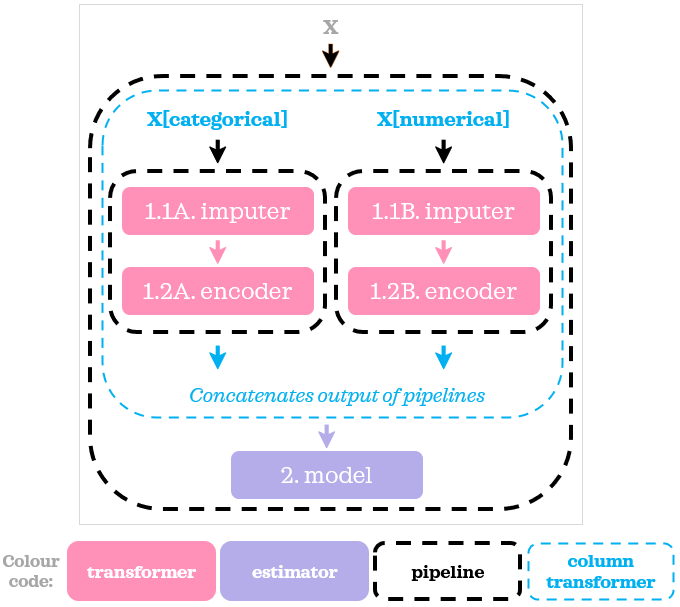

In [82]:
from sklearn.compose import ColumnTransformer

tr3 = ColumnTransformer(transformers=[('Scaler',StandardScaler(), numeric_cols)], remainder='passthrough')
# try without remainder
tr3.fit(X_train)
tr3.transform(X_train)

array([[-0.5777748145912736, 0.4436870059803722, 0.40100042165117517,
        ..., 'No', 'No', 'No'],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [0.05072532530008883, -0.9038068640340915, 2.0189373619797664,
        ..., 'No', 'Yes', 'No'],
       [0.19039202305372485, 0.14789566866012407, -0.24452620140013012,
        ..., 'No', 'No', 'No'],
       [-0.0470413631274565, -0.016432852073347118, -0.29671771560427823,
        ..., 'No', 'No', 'No']], dtype=object)

In [83]:
pd.DataFrame(tr3.transform(X_train), columns=X_train.columns).head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin,price_up_200k
0,-0.577775,0.443687,0.401,-1.32423,-2.0812,-1.37465,-1.34214,-0.870721,0.888754,-0.811575,electric,electric,septic,No,No,No
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.130841,-0.509418,-0.458786,0.340617,-0.485116,-0.153918,-0.588315,-0.870721,0.888754,-0.811575,hot air,gas,septic,No,No,No
4,-0.549841,-0.936673,-0.560422,-1.43008,-0.485116,-1.37465,-1.34214,-1.74493,-1.12517,-0.811575,hot air,gas,public/commercial,No,Yes,Yes


In [84]:
from sklearn import impute
imp = impute.SimpleImputer(strategy='median')
# imp.fit(datos)
imp.fit(datos_num)
pd.DataFrame(imp.transform(datos_num), columns=datos_num.columns).head()



,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,price_up_200k
0,0.09,42.0,50000.0,906.0,35.0,2.0,1.0,5.0,1.0,0.0
1,0.36,19.0,25100.0,1602.5,57.0,3.0,2.0,7.0,1.0,0.0
2,0.36,19.0,25100.0,1602.5,57.0,3.0,2.0,7.0,1.0,0.0
3,0.41,13.0,18700.0,1944.0,51.0,3.0,1.5,5.0,1.0,0.0
4,0.11,0.0,15000.0,840.0,51.0,2.0,1.0,3.0,0.0,0.0


In [85]:
imp = impute.SimpleImputer(strategy='mean')
# imp.fit(datos)
imp.fit(datos_num)
pd.DataFrame(imp.transform(datos_num), columns=datos_num.columns).head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,price_up_200k
0,0.090000,42.0,50000.000000,906.000000,35.000000,2.000000,1.000000,5.000000,1.000000,0.000000
1,0.503681,28.5,35401.826087,1731.631159,55.863043,3.126087,1.890217,6.992029,0.558696,0.397101
2,0.503681,28.5,35401.826087,1731.631159,55.863043,3.126087,1.890217,6.992029,0.558696,0.397101
3,0.410000,13.0,18700.000000,1944.000000,51.000000,3.000000,1.500000,5.000000,1.000000,0.000000
4,0.110000,0.0,15000.000000,840.000000,51.000000,2.000000,1.000000,3.000000,0.000000,0.000000


In [86]:
tr4 = ColumnTransformer(transformers=[('Imputer', impute.SimpleImputer(), numeric_cols), ('Scaler2',StandardScaler(), numeric_cols)], remainder='passthrough')
# try without remainder
tr4.fit(X_train)
tt = tr4.transform(X_train)
pd.DataFrame(tt).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.09,42,50000,906,35,2,1,5,1,0,...,-1.34214,-0.870721,0.888754,-0.811575,electric,electric,septic,No,No,No
1,0.503681,28.5,35401.8,1731.63,55.863,3.12609,1.89022,6.99203,0.558696,0.397101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.503681,28.5,35401.8,1731.63,55.863,3.12609,1.89022,6.99203,0.558696,0.397101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.41,13,18700,1944,51,3,1.5,5,1,0,...,-0.588315,-0.870721,0.888754,-0.811575,hot air,gas,septic,No,No,No
4,0.11,0,15000,840,51,2,1,3,0,0,...,-1.34214,-1.74493,-1.12517,-0.811575,hot air,gas,public/commercial,No,Yes,Yes


In [87]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )

tr5 = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                    ],
                    remainder='passthrough'
                )

tr5.fit(X_train)
tt = tr5.transform(X_train)
pd.DataFrame(tt, columns=X_train.columns).head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir,fireplaces_bin,price_up_200k
0,-0.577886,0.444429,0.401677,-1.32484,-2.08286,-1.3754,-1.34333,-0.871357,0.887603,-0.810601,electric,electric,septic,No,No,No
1,-0.200524,-0.311976,-0.282762,-0.206957,0.113335,-0.153804,0.165392,0.00348163,0.887603,-0.810601,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.200524,-0.311976,-0.282762,-0.206957,0.113335,-0.153804,0.165392,0.00348163,0.887603,-0.810601,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.130642,-0.509299,-0.458682,0.341154,-0.485627,-0.153804,-0.588969,-0.871357,0.887603,-0.810601,hot air,gas,septic,No,No,No
4,-0.549933,-0.936833,-0.560386,-1.43077,-0.485627,-1.3754,-1.34333,-1.7462,-1.12663,-0.810601,hot air,gas,public/commercial,No,Yes,Yes


> your turn: create a pipeline for categorical columns impute and hot encoder

# MODEL

In [88]:
X_train.isna().sum()

lotSize            2
age                2
landValue          2
livingArea         2
pctCollege         2
bedrooms           2
bathrooms          2
rooms              2
heating            2
fuel               2
sewer              2
waterfront         2
newConstruction    2
centralAir         2
fireplaces_bin     2
price_up_200k      2
dtype: int64

In [89]:
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [93]:
X_train_prep

array([[-0.57788588,  0.44442923,  0.40167745, ...,  0.        ,
         1.        ,  0.        ],
       [-0.20052363, -0.31197618, -0.28276188, ...,  0.        ,
         1.        ,  0.        ],
       [-0.20052363, -0.31197618, -0.28276188, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.0510512 , -0.90394563,  2.02069257, ...,  1.        ,
         1.        ,  0.        ],
       [ 0.190815  ,  0.1484445 , -0.24427935, ...,  0.        ,
         1.        ,  0.        ],
       [-0.04678345, -0.01599146, -0.29650565, ...,  0.        ,
         1.        ,  0.        ]])

In [92]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================

encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.head()

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,bathrooms,rooms,fireplaces_bin,price_up_200k,...,fuel_oil,sewer_none,sewer_public/commercial,sewer_septic,waterfront_No,waterfront_Yes,newConstruction_No,newConstruction_Yes,centralAir_No,centralAir_Yes
0,-0.577886,0.444429,0.401677,-1.324844,-2.082857,-1.375398,-1.343329,-0.871357,0.887603,-0.810601,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.200524,-0.311976,-0.282762,-0.206957,0.113335,-0.153804,0.165392,0.003482,0.887603,-0.810601,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-0.200524,-0.311976,-0.282762,-0.206957,0.113335,-0.153804,0.165392,0.003482,0.887603,-0.810601,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,-0.130642,-0.509299,-0.458682,0.341154,-0.485627,-0.153804,-0.588969,-0.871357,0.887603,-0.810601,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,-0.549933,-0.936833,-0.560386,-1.430775,-0.485627,-1.375398,-1.343329,-1.746195,-1.126629,-0.810601,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [94]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['lotSize', 'age', 'landValue', 'livingArea',
                                  'pctCollege', 'bedrooms', 'bathrooms',
                                  'rooms', 'fireplaces_bin', 'price_up_200k']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['heating', 'fuel', 'sewer', 'waterfront',
                                  'newConstruction', 'centralAir'])])

# Create a model

The next step after defining the training data is to select the algorithm to be used. In scikit-learn, this is done by creating an estimator object. Specifically, this object stores the name of the algorithm, its parameters and hyperparameters, and contains the fit (X, y) and predict (T) methods that allow it to learn from the data and predict new observations. The following list contains all the algorithms implemented in scikit-learn.

## Training

A first linear regression model with ridge regularization is fitted to predict house prices based on all available predictors. All arguments to sklearn.linear_model.Ridge are left by default.

It is important to note that when a linear regression model includes regularization in the coefficients (ridge, lasso, elasticnet), the predictors must be standardized. To ensure that preprocessing is done only with training data, transformations and training are combined in a single pipeline.

In [100]:
from sklearn.linear_model import Ridge

m_ridge_1 = Ridge()
# m_ridge_1.fit(X_train, y_train) # ValueError: could not convert string to float: 'electric'
m_ridge_1.fit(X_train_prep, y_train)

Ridge()

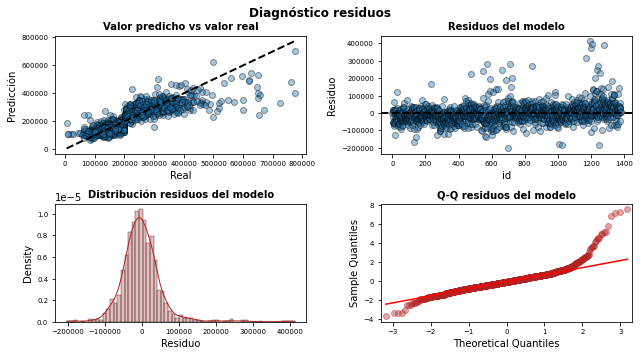

In [102]:
model_diagnosis(X_train=X_train_prep, pipe=m_ridge_1, y_train=y_train)

In [103]:
# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
pipe.fit(X=X_train, y=y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lotSize', 'age',
                                                   'landValue', 'livingArea',
                                                   'pctCollege', 'bedrooms',
                                                   'bathrooms', 'rooms',
                                                   'fireplaces_bin',
                                                   'price_up_200k']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['heating', 'fuel', 'sewer',
                                                   'waterfront',
                                                   'newConstruction',
                                                   'centralAir'])])),
                ('modelo', Ridge())])

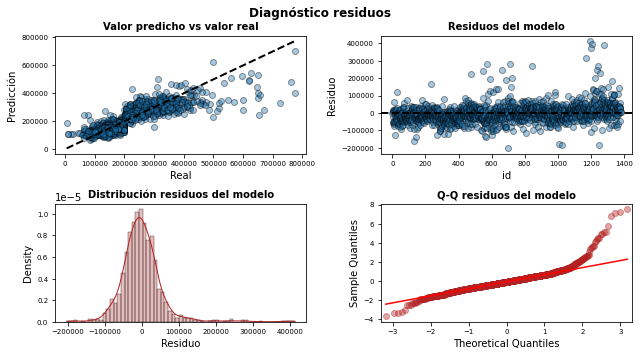

In [104]:
model_diagnosis(X_train=X_train, pipe=pipe, y_train=y_train)

## Validation


The ultimate purpose of a model is to predict the response variable in future observations or in observations that the model has not "seen" before. The default error displayed after training a model is usually the training error, the error the model makes in predicting the observations it has already "seen." While these errors are helpful in understanding how the model is learning (residual study), they are not a realistic estimate of how the model behaves in the face of new observations (the training error is often too optimistic). To achieve a more accurate estimate, and before resorting to the test set, validation strategies based on resampling can be used. Scikit-learn incorporates several validation strategies into the sklearn.model_selection module.

All of them receive as their first argument an estimator that can be directly a model or a pipeline.

Regression error metrics are always returned negative, so the closer to 0 the value, the better the fit. This is so so that optimization processes are always maximization.

The easiest way is to use the cross_val_score () function, which KFold uses by default.

In [106]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-39785.95951497 -45610.66025987 -58876.20650975 -43555.82125964
 -77935.74430289]
Média métricas de validación cruzada: -53152.878369424376


It is also possible to use other cross-validation strategies (KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit) by pre-casting with the helper functions of sklearn.model_selection and passing the indices to the cv argument.

Each method works differently internally, but all of them are based on the idea: to adjust and evaluate the model repeatedly, using different subsets created from the training data each time, obtaining an estimate of the error in each repetition. The average of all estimates tends to converge on the true value of the test error. Appendix 1

In [107]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv
             )

print(f"Métricas de validación cruzada: {cv_scores}")
print("")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas de validación cruzada: [-53515.81632417 -48557.72850784 -66113.58859107 -45209.30346637
 -51065.74230475 -50682.40401834 -59047.06666343 -43734.66121875
 -53401.08588367 -55864.33952914 -52582.53137382 -50628.66392986
 -57216.62384973 -53417.29299889 -50192.45999546 -47666.73088914
 -57080.71048967 -54380.61257239 -51219.13652095 -54747.37446823
 -43937.70217247 -62458.66220662 -46394.65259602 -48393.78237207
 -61737.52978271]

Média métricas de validación cruzada: -52769.84810902223


The cross_validate function is similar to cross_val_score but it allows estimating several metrics at the same time, for both test and train, and returns the results in a dictionary.

In [112]:
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.023009,0.010977,0.712309,0.743899,-53026.601686,-52225.390862
1,0.026979,0.011993,0.723934,0.735127,-59876.452220,-48891.740167
2,0.022985,0.009995,0.711223,0.742815,-48821.718180,-54110.080608
3,0.031988,0.010005,0.700573,0.753256,-56123.693796,-50326.880236
4,0.016010,0.005041,0.790166,0.707824,-46730.644278,-54917.971371
5,0.015647,0.015605,0.694788,0.755176,-55565.035770,-50650.481787
6,0.015643,0.015601,0.755326,0.725512,-50241.590767,-53372.532934
7,0.015624,0.015645,0.689548,0.756438,-55839.125428,-50603.290811
8,0.015625,0.015605,0.737144,0.735176,-53060.140656,-51926.609182
9,0.015624,0.015642,0.722710,0.740627,-53449.164182,-51896.802968


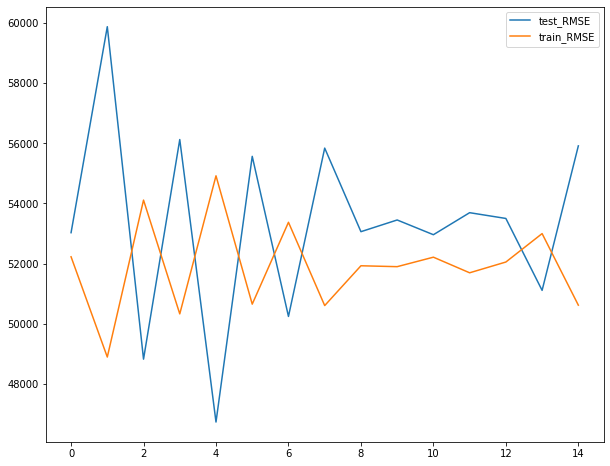

In [122]:
plt.plot(-cv_scores['test_neg_root_mean_squared_error'])
plt.plot(-cv_scores['train_neg_root_mean_squared_error'])
plt.legend(labels=['test_RMSE', 'train_RMSE'])

The cross_val_predict function, instead of returning the metric for each partition, returns the predictions for each partition. This is useful to be able to evaluate the residuals of the model and diagnose its behavior. If bootstrapping or repeated cross-validation is used, the same observation can be part of the validation partition multiple times.

For practical purposes, when resampling methods are applied to validate a model, two things must be taken into account: the computational cost involved in fitting a model multiple times, each time with a different subset of data, and the reproducibility in the creation of the data. partitions. The cross_val_score () and cross_val_predict functions allow you to parallelize the process using the n_jobs argument.

In [109]:
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)
cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = cv,
                n_jobs    = -1 # todos los cores disponibles
             )

print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Média métricas de validación cruzada: -52549.11333426685


The average root_mean_squared_error estimated by cross-validation for the ridge model is 52549. This value will be checked later when the error of the model is calculated with the test set.

## Prediction


Once the model has been trained, either directly using an estimator or a pipeline, new observations can be predicted with the .predict () method. If a pipeline is used, the transformations learned during training are applied automatically.

In [118]:
predicciones = pipe.predict(X_test)

In [119]:
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

,precio,prediccion
1382,328463,359848.939391
1383,185000,130003.987701
1384,128000,104063.088717
1385,335000,286146.393440
1386,148900,112038.467993


## Test error


Although through validation methods (Kfold, LeaveOneOut) good estimates of the error that a model has when predicting new observations are obtained, the best way to evaluate a final model is by predicting a test set, that is, a set of observations that has been kept out of the training and optimization process. Depending on the problem in question, some Annex 2 metrics or others may be interesting. The sklearn.metrics module incorporates a considerable variety of metrics to evaluate the quality of the predictions.

In [123]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
rmse

41632.22532239764

In the validation section, it was estimated, by repeated cross-validation, that the rmse of the model was 56735, a value close to that obtained with the 65372 test set.

# Hyperparameters (tuning)


Many models, including linear regression with Ridge regularization, contain parameters that cannot be learned from the training data and therefore must be established by the analyst. These are known as hyperparameters. The results of a model can depend to a great extent on the value that its hyperparameters take, however, it is not possible to know in advance which is the appropriate one. Although with practice, machine learning specialists gain insight into which values ​​may work best for each problem, there are no hard and fast rules. The most common way to find optimal values ​​is by trying different possibilities.

1. Choose a set of values ​​for the hyperparameter (s).

- grid search: an exhaustive search is made on a set of values ​​previously defined by the user.

- random search: random values ​​are evaluated within user-defined limits.

2. For each value (combination of values ​​if there is more than one hyperparameter), train the model and estimate its error using a validation method Annex 1.

3. Finally, fit the model again, this time with all the training data and the best hyperparameters found.

Scikilearn allows exploring different hyperparameter values using `model_selection.GridSearchCV ()` and `model_selection.RandomizedSearchCV ()`

## Grid search
The `Ridge` model used so far has a hyperparameter called alpha, which by default has the value 1.0. This hyperparameter controls the penalty that is applied to the model coefficients. The higher its value, the more restriction is imposed on the coefficients, thus reducing variance, attenuating the effect of the correlation between predictors and minimizing the risk of overfitting.

A Ridge model is re-fitted with different alpha values using repeated cross-validation to identify which yields the best results.

In [ ]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

In [156]:
Ridge().get_params().keys()
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'modelo', 'preprocessing__n_jobs', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__numeric', 'preprocessing__cat', 'preprocessing__numeric__memory', 'preprocessing__numeric__steps', 'preprocessing__numeric__verbose', 'preprocessing__numeric__imputer', 'preprocessing__numeric__scaler', 'preprocessing__numeric__imputer__add_indicator', 'preprocessing__numeric__imputer__copy', 'preprocessing__numeric__imputer__fill_value', 'preprocessing__numeric__imputer__missing_values', 'preprocessing__numeric__imputer__strategy', 'preprocessing__numeric__imputer__verbose', 'preprocessing__numeric__scaler__copy', 'preprocessing__numeric__scaler__with_mean', 'preprocessing__numeric__scaler__with_std', 'preprocessing__cat__memory', 'preprocessing__cat__steps', 'preprocessing__cat__verbose', 'preprocessing__cat__imputer', 'p

In [158]:
# Grid de hiperparámetros
# ==============================================================================
param_grid = {'modelo__alpha': np.logspace(-5, 3, 10)}

In [159]:
np.logspace(-5, 3, 10)

array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03])

In [160]:
import multiprocessing
multiprocessing.cpu_count()

4

In [161]:
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
#         n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        return_train_score = True
       )

In [162]:
%%time

grid.fit(X = X_train, y = y_train)

Wall time: 10.7 s


GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=None),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['lotSize',
                                                                          'age',
                                                                          'landValue',
                                                                          'livingArea',
                                                                          'pctCollege',
                                                                          'bedrooms',
                                                                          'bathrooms'...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['heating',
                                                                          'fuel',
                                                                          'sewer',
                                                                          'waterfront',
                                                                          'newConstruction',
                                                                          'centralAir'])])),
                                       ('modelo', Ridge())]),
             param_grid={'modelo__alpha': array([1.00000000e-05, 7.74263683e-05, 5.99484250e-04, 4.64158883e-03,
       3.59381366e-02, 2.78255940e-01, 2.15443469e+00, 1.66810054e+01,
       1.29154967e+02, 1.00000000e+03])},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [135]:
# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)

,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
6,2.15443,-52825.671782,5179.221675,-52054.653618,1367.095012
5,0.278256,-52840.201781,5185.083542,-52047.248203,1367.623784
4,0.0359381,-52843.459206,5186.124820,-52047.101134,1367.635167
3,0.00464159,-52843.908082,5186.265368,-52047.098621,1367.635363
2,0.000599484,-52843.966540,5186.283625,-52047.098579,1367.635366
1,7.74264e-05,-52843.974098,5186.285984,-52047.098578,1367.635367
0,1e-05,-52843.975074,5186.286289,-52047.098578,1367.635367
7,16.681,-52921.658101,5170.359059,-52227.333457,1359.092150
8,129.155,-53732.339987,5148.971307,-53233.560904,1332.473560
9,1000,-59326.223025,5032.554170,-59165.800287,1207.754054


In [136]:
print("-----------------------------------")
print("Mejores hiperparámetros encontrados")
print("-----------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

-----------------------------------
Mejores hiperparámetros encontrados
-----------------------------------
{'modelo__alpha': 2.154434690031882} : -52825.6717819924 neg_root_mean_squared_error


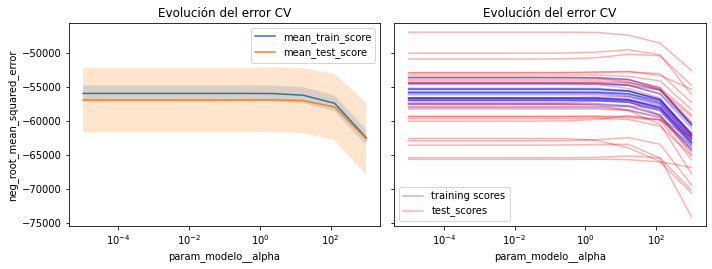

In [46]:
# ==============================================================================
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.84), sharey=True)

# Gráfico 1
# ------------------------------------------------------------------------------
resultados.plot('param_modelo__alpha', 'mean_train_score', ax=axes[0])
resultados.plot('param_modelo__alpha', 'mean_test_score', ax=axes[0])
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
axes[0].fill_between(resultados.param_modelo__alpha.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
axes[0].legend()
axes[0].set_xscale('log')
axes[0].set_title('Evolución del error CV')
axes[0].set_ylabel('neg_root_mean_squared_error');

# Gráfico 2
# ------------------------------------------------------------------------------
numero_splits = grid.n_splits_

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_train_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'blue', 
    ax    = axes[1]
)

resultados.plot(
    x     = 'param_modelo__alpha',
    y     = [f'split{i}_test_score' for i in range(numero_splits)],
    alpha = 0.3,
    c     = 'red', 
    ax    = axes[1]
)

axes[1].legend(
    (axes[1].get_children()[0], axes[1].get_children()[numero_splits]),
    ('training scores', 'test_scores')
)
axes[1].set_xscale('log')
axes[1].set_title('Evolución del error CV')
axes[1].set_ylabel('neg_root_mean_squared_error');

fig.tight_layout()


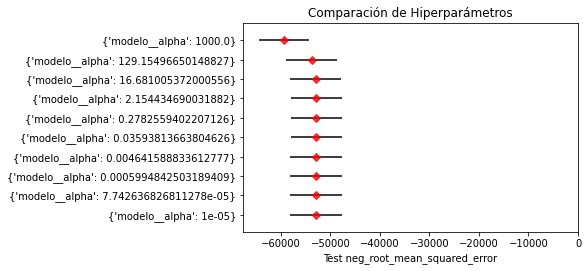

In [163]:
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_xlabel('Test neg_root_mean_squared_error');

If refit = True is indicated in GridSearchCV (), after identifying the best hyperparameters, the model is retrained with them and stored in .best_estimator_.

In [166]:
estimator = grid.best_estimator_

In [171]:
pred = estimator.predict(X_test)


In [176]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_pred=pred, y_true=y_test, squared=False)

41636.88291545737

In [204]:
import joblib

# save
joblib.dump(estimator, "model.joblib") 

['model.joblib']

In [205]:
# load
clf2 = joblib.load("model.joblib")

In [206]:
clf2.predict(X_test)[:4]

array([360297.98174912, 130055.99179794, 104129.76420587, 286106.34947541])

In [200]:
np.sum(clf2.predict(X_test) - pred)

0.0

# And finally... DEPLOY your model!

[![IMAGE ALT TEXT HERE](https://img.youtube.com/vi/MaKLWy5zXe8/0.jpg)](https://www.youtube.com/watch?v=MaKLWy5zXe8)


# Random forest

In [183]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [180]:
pipe_rf = Pipeline([('prep', preprocessor), ('rf', RandomForestRegressor())])

In [189]:
pipe_rf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'prep', 'rf', 'prep__n_jobs', 'prep__remainder', 'prep__sparse_threshold', 'prep__transformer_weights', 'prep__transformers', 'prep__verbose', 'prep__numeric', 'prep__cat', 'prep__numeric__memory', 'prep__numeric__steps', 'prep__numeric__verbose', 'prep__numeric__imputer', 'prep__numeric__scaler', 'prep__numeric__imputer__add_indicator', 'prep__numeric__imputer__copy', 'prep__numeric__imputer__fill_value', 'prep__numeric__imputer__missing_values', 'prep__numeric__imputer__strategy', 'prep__numeric__imputer__verbose', 'prep__numeric__scaler__copy', 'prep__numeric__scaler__with_mean', 'prep__numeric__scaler__with_std', 'prep__cat__memory', 'prep__cat__steps', 'prep__cat__verbose', 'prep__cat__imputer', 'prep__cat__onehot', 'prep__cat__imputer__add_indicator', 'prep__cat__imputer__copy', 'prep__cat__imputer__fill_value', 'prep__cat__imputer__missing_values', 'prep__cat__imputer__strategy', 'prep__cat__imputer__verbose', 'prep__cat__onehot__categori

In [201]:
param_grid = { 
    'rf__n_estimators': [200, 500],
    'rf__max_depth' : [4,5,6,7,8],
}

In [202]:
CV_rfr = GridSearchCV(estimator=pipe_rf, param_grid=param_grid, cv= 5,)

Wall time: 0 ns


In [203]:
%%time
CV_rfr.fit(X_train, y_train)

KeyboardInterrupt: 